In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pyyaml h5py  # Required to save models in HDF5 format

In [3]:
# @title # Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Dataset

In [5]:
file_dir = "/content/drive/MyDrive/PU-Y4-S2/Xử lý ngôn ngữ tự nhiên/Midterm/Sentiment_Analysis/Twitter_Data.csv"


In [6]:
# @title ## Read data
data= pd.read_csv(file_dir)
print("The Shape of the Dataset".format(),data.shape)
data.head()

The Shape of the Dataset (162980, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [7]:
# @title ## Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [8]:
# Identifying missing values
null_values = data.isnull().sum()
null_values

clean_text    4
category      7
dtype: int64

In [9]:
# Remove data is null
data = data.dropna(how='any',axis=0)

In [10]:
data['category'].value_counts()

 1.0    72249
 0.0    55211
-1.0    35509
Name: category, dtype: int64

In [11]:
# Identify duplicates
num_duplicates = data.duplicated().sum()
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 0 duplicate reviews present in the dataset


## Processing

In [12]:
# Converting target variable to onehot vector
labels = pd.get_dummies(data.category)
labels.columns = ["negative", "neutral", "positive"]
data["negative"] = labels["negative"]
data["neutral"] = labels["neutral"]
data["positive"] = labels["positive"]

In [13]:
data.head()

,clean_text,category,negative,neutral,positive
0,when modi promised “minimum government maximum...,-1.0,1,0,0
1,talk all the nonsense and continue all the dra...,0.0,0,1,0
2,what did just say vote for modi welcome bjp t...,1.0,0,0,1
3,asking his supporters prefix chowkidar their n...,1.0,0,0,1
4,answer who among these the most powerful world...,1.0,0,0,1


### Clean data

In [14]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [15]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [16]:
# Function to clean data
def clean_text(text,lemmatize = True):
    # Remove html tags
    html_tag=re.compile(r'<.*?>')
    text=html_tag.sub(r'',text)
    # Expanding chatwords and contracts clearing contractions
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    # Remove emoji
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    # Add space after full stop
    text = re.sub(r'\.(?=\S)', '. ',text)
    # Remove urls
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    # Lemmatize or remove stop words
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()])
    return text

In [17]:
# Retain original data
data_copy = data.copy()

In [18]:
# Apply cleaning data
data['clean_text']=data['clean_text'].apply(clean_text,lemmatize = True)

In [19]:
# After converting labels
data.head()

,clean_text,category,negative,neutral,positive
0,modi promised government maximum expected begi...,-1.0,1,0,0
1,talk nonsense continue drama vote modi,0.0,0,1,0
2,say vote modi welcome bjp told rahul main camp...,1.0,0,0,1
3,asking supporter prefix chowkidar name modi gr...,1.0,0,0,1
4,answer among powerful world leader today trump...,1.0,0,0,1


## Exploratory data analysis

<Axes: xlabel='category', ylabel='count'>

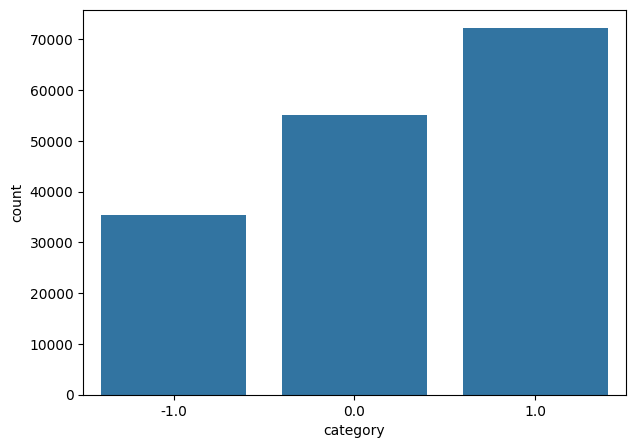

In [20]:
# Count Plot
fig = plt.figure(figsize=(7,5))
sns.countplot(x="category",data=data)

Text(0.5, 1.0, 'Distribution of sentiments')

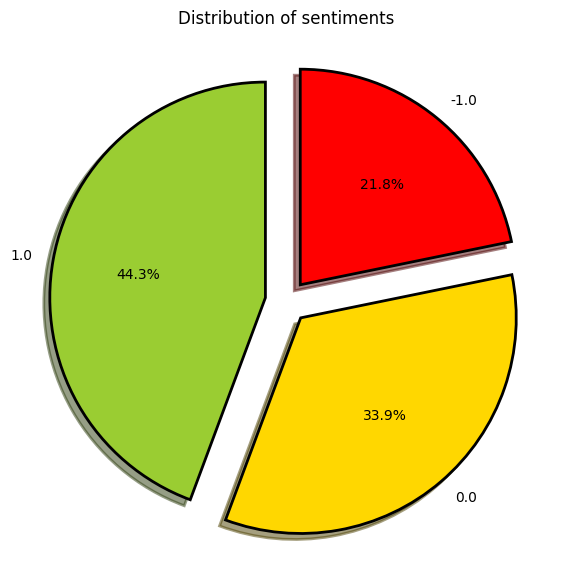

In [21]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = data['category'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

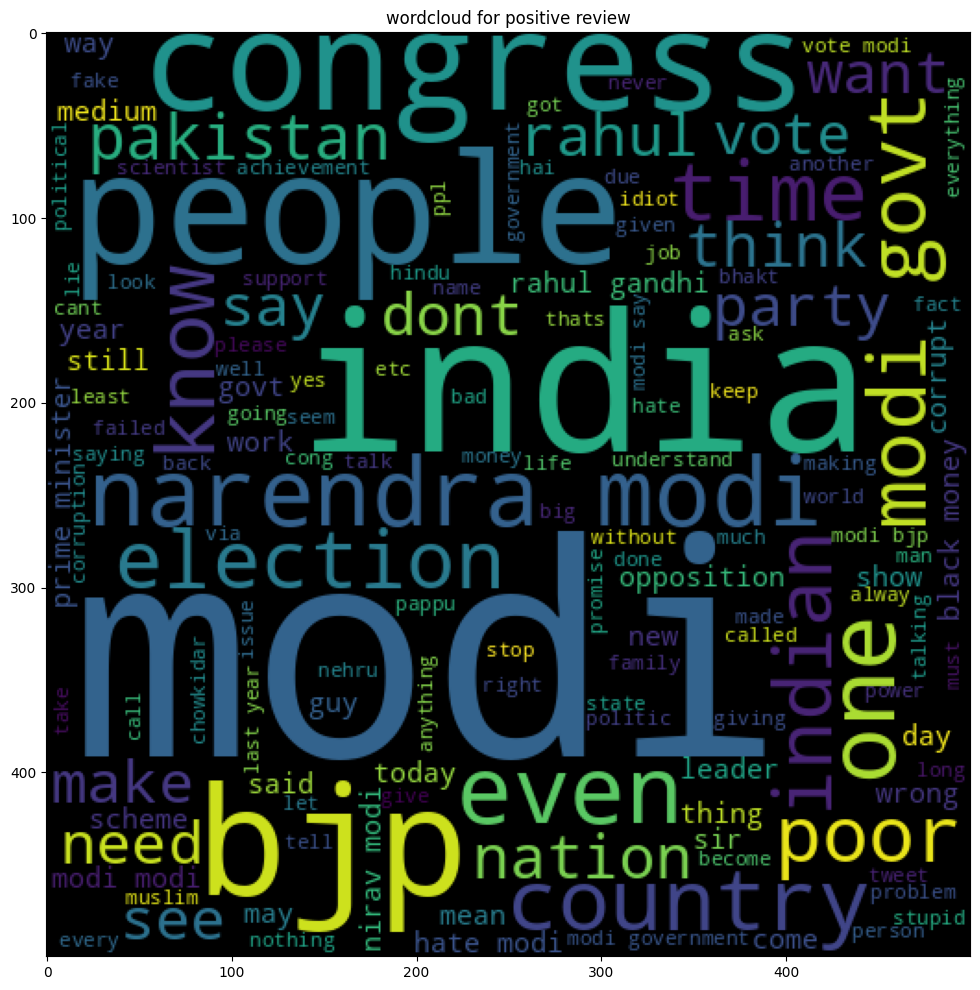

In [22]:
# Word cloud for positive reviews
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
positive_wc = wc.generate(data[data['category'] == 1.0]['clean_text'].str.cat(sep = " "))
neutral_wc = wc.generate(data[data['category'] == 0.0]['clean_text'].str.cat(sep = " "))
negative_wc = wc.generate(data[data['category'] == -1.0]['clean_text'].str.cat(sep = " "))
plt.figure(figsize = (12, 12))
plt.title('wordcloud for positive review')
plt.imshow(positive_wc)

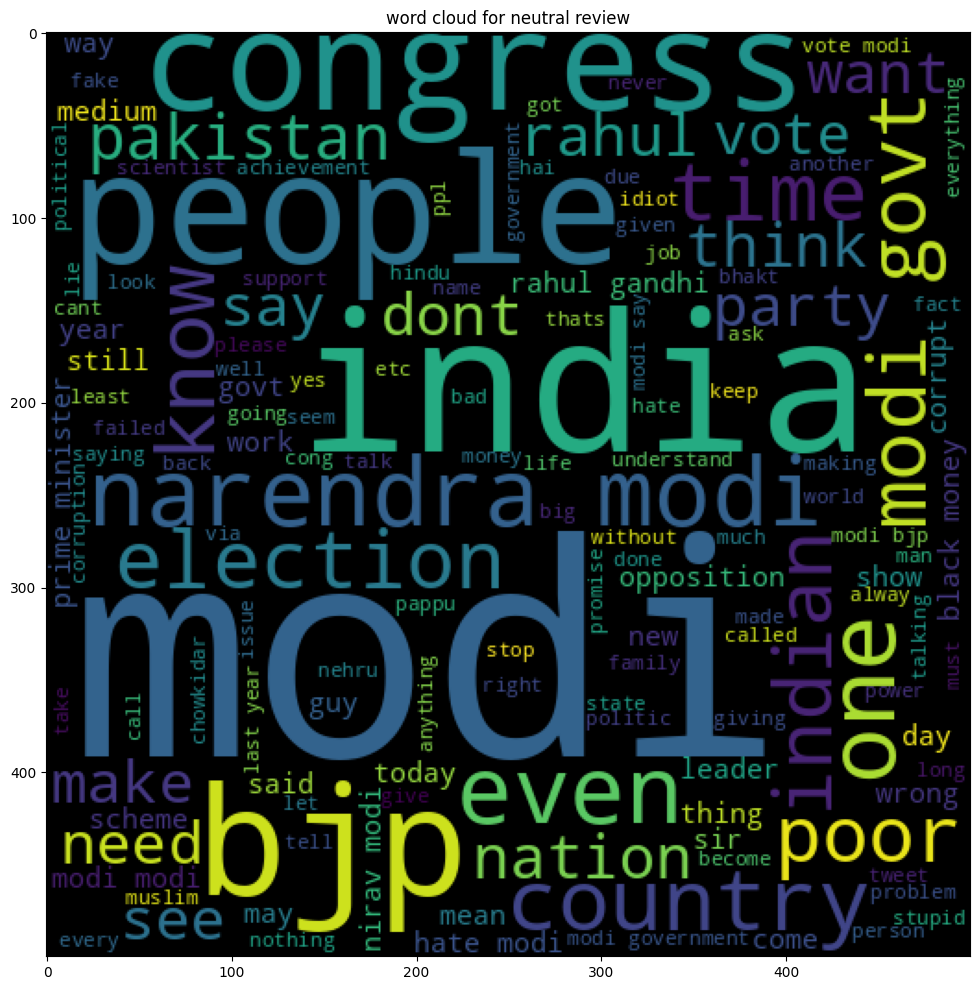

In [23]:
# Word cloud for neutral reviews
plt.figure(figsize = (12, 12))
plt.title('word cloud for neutral review')
plt.imshow(neutral_wc)

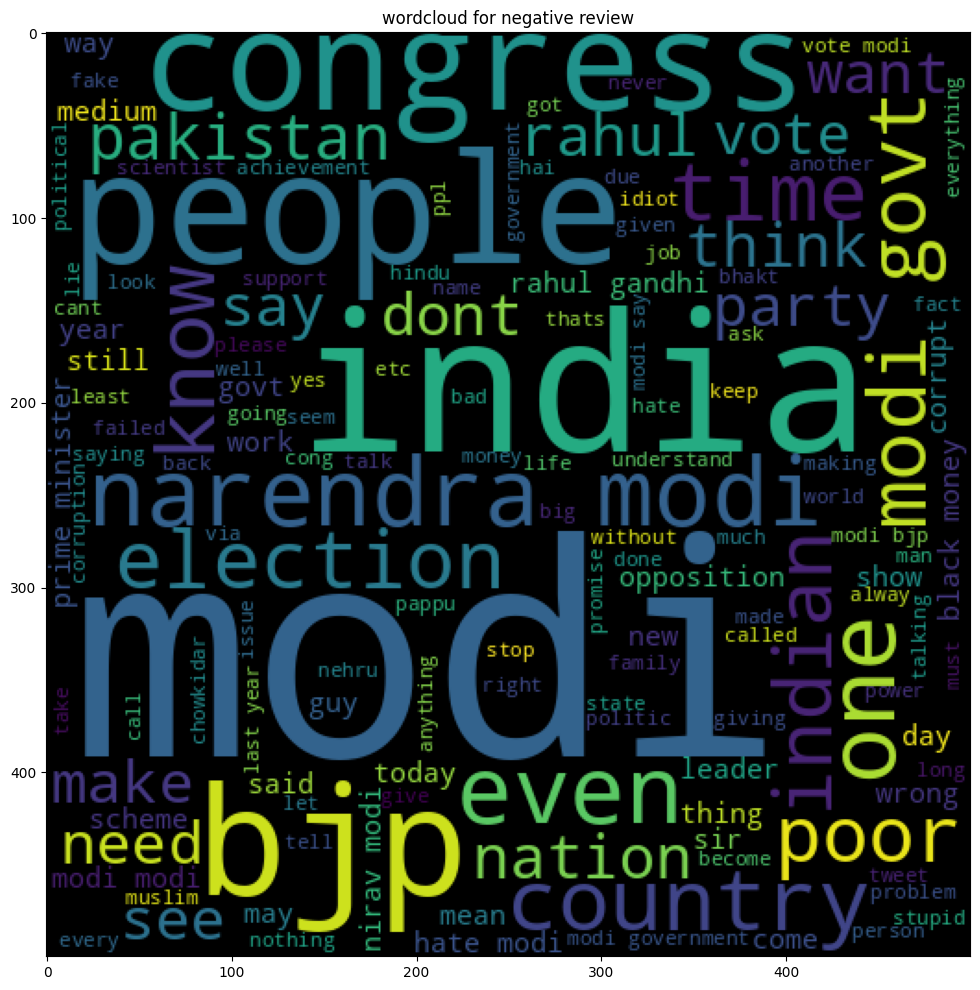

In [24]:
# Word cloud for negative reviews
plt.figure(figsize = (12, 12))
plt.title('wordcloud for negative review')
plt.imshow(negative_wc)


In [25]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.clean_text)
corpus[:5]

['modi', 'promised', 'government', 'maximum', 'expected']

In [26]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,modi,152412
1,india,30144
2,bjp,14488
3,people,14288
4,like,12931
5,congress,12820
6,election,11663
7,narendra,11432
8,vote,10857
9,govt,9879


In [27]:
most_common = most_common.sort_values('countv')

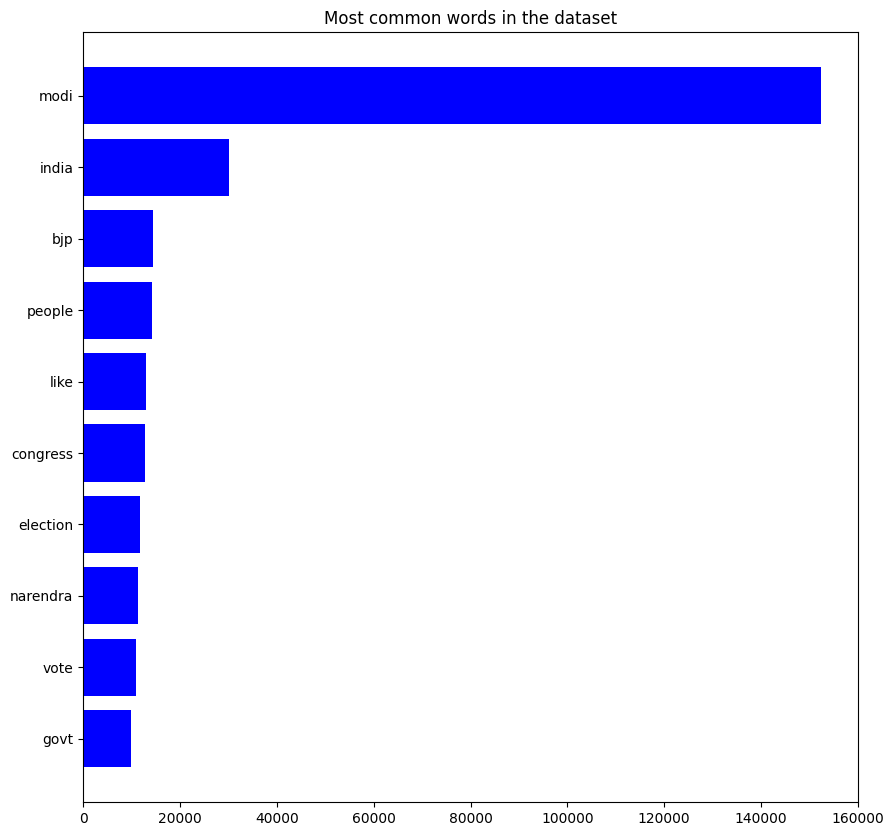

In [28]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [29]:
data.category = data.category + 1
data.head()

,clean_text,category,negative,neutral,positive
0,modi promised government maximum expected begi...,0.0,1,0,0
1,talk nonsense continue drama vote modi,1.0,0,1,0
2,say vote modi welcome bjp told rahul main camp...,2.0,0,0,1
3,asking supporter prefix chowkidar name modi gr...,2.0,0,0,1
4,answer among powerful world leader today trump...,2.0,0,0,1


# Predictive Modelling using Machine Learning

In [30]:
# @title ## Splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['clean_text'], train['category']
Xtest, ytest = test['clean_text'], test['category']

In [31]:
# @title ## Vectorizing data

# tfidfVectorizer
tfidf_vect = TfidfVectorizer()
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)

# # CountVectorizer
# count_vect = CountVectorizer()
# Xtrain_count = count_vect.fit_transform(Xtrain)
# Xtest_count = count_vect.transform(Xtest)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy : 87.82%


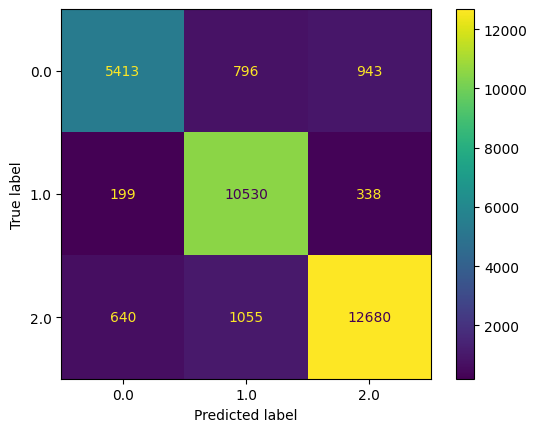

In [32]:
# @title ## Logistic Regression

lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))
ConfusionMatrixDisplay.from_estimator(lr, Xtest_tfidf, ytest)
plt.grid(False)
plt.show()


Multinomial Naive Bayes Classifier Accuracy : 57.78%


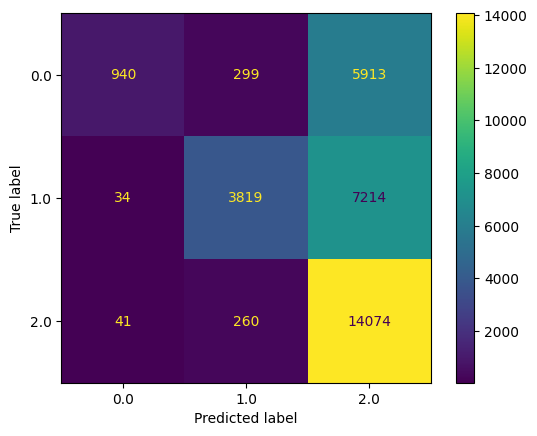

In [33]:
# @title ## Multinomial Naive Bayes

mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
p2=mnb.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))
ConfusionMatrixDisplay.from_estimator(mnb, Xtest_tfidf, ytest)
plt.grid(False)
plt.show()


XGBoost Accuracy : 82.37%


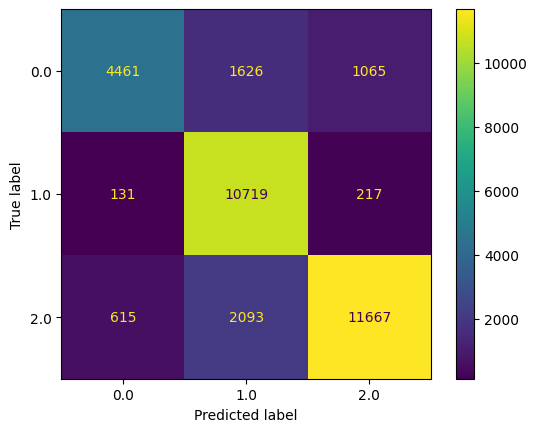

In [34]:
# @title ## XGboost

xgbo = XGBClassifier()
xgbo.fit(Xtrain_tfidf,ytrain)
p4=xgbo.predict(Xtest_tfidf)
s4=accuracy_score(ytest,p4)
print("XGBoost Accuracy :", "{:.2f}%".format(100*s4))
ConfusionMatrixDisplay.from_estimator(xgbo, Xtest_tfidf, ytest)
plt.grid(False)
plt.show()


# Predictive Modelling using Deep Learning


In [35]:
# @title ## Splitting into train and test
data_copy['clean_text']=data_copy['clean_text'].apply(clean_text,lemmatize = False)

Xtrain, Xtest,  ytrain, ytest = train_test_split(data_copy['clean_text'], labels, test_size=0.2, random_state=42)


In [36]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))

  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

## LSTM

In [37]:
# Set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  86688


In [38]:
# Create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [39]:
# Choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

# If we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 43


In [40]:
# When setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 29


In [41]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 97.17 % of data


In [42]:
# Create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [43]:
# Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain, test_size=0.2,random_state=10)

In [44]:
def lstm_model(Xtrain, Xval, ytrain, yval, V, D, maxlen, epochs):
    # V: number of words in vocabulary of the dataset
    # D: embedding dims
    # maxlen: maximum length of sequences
    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D, input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_accuracy',
                               mode='min',
                               patience = 2 )
    checkpoints= ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True)
    callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain,
                  validation_data = (Xval,yval),
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32,
                  callbacks = callbacks)
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])

    return r, model, n_epochs

In [45]:
D = 64 # embedding dims
epochs = 5
r, model_lstm, n_epochs = lstm_model(Xtrain, Xval, ytrain, yval, V, D, max_seq_len, epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 embedding (Embedding)       (None, 29, 64)            5548096   
                                                                 
 batch_normalization (Batch  (None, 29, 64)            256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 29, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 25, 32)            10272     
                                                                 
 dropout_1 (Dropout)         (None, 25, 32)            0         
                                  

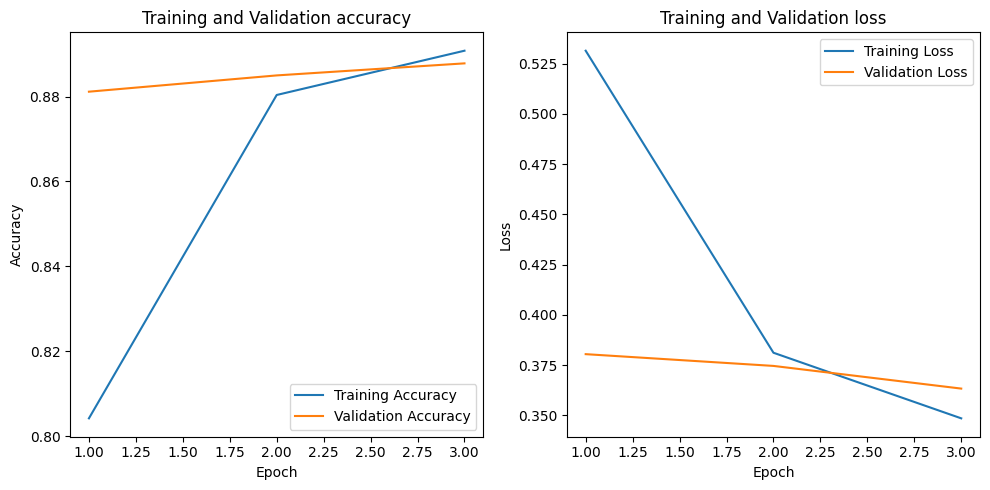

In [46]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [47]:
print("Evaluate Model Performance on Test set")
result = model_lstm.evaluate(pad_test,ytest)
print(dict(zip(model_lstm.metrics_names, result)))

Evaluate Model Performance on Test set
1019/1019 [==============================] - 6s 5ms/step - loss: 0.3625 - accuracy: 0.8875
{'loss': 0.3625350594520569, 'accuracy': 0.8874639272689819}


1019/1019 [==============================] - 4s 4ms/step


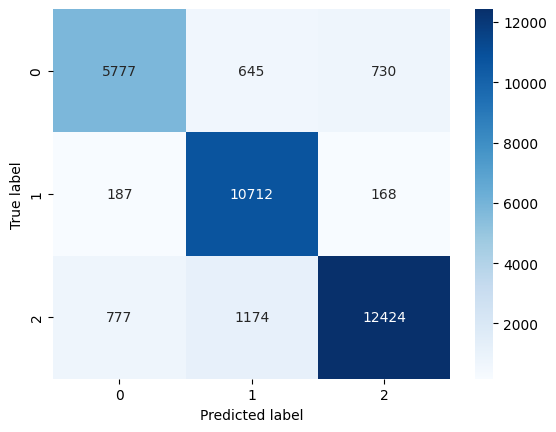

In [50]:
#Generate predictions for the test dataset
ypred = model_lstm.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest.values.argmax(axis=1), ypred.argmax(axis=1))
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [51]:
# Save mdel
path_lstm = '/content/drive/MyDrive/PU-Y4-S2/Xử lý ngôn ngữ tự nhiên/Midterm/Sentiment_Analysis/Twitter Model/model_lstm.h5'
model_lstm.save(path_lstm)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## BERT

In [52]:
# @title ### Splitting
data_copy['clean_text']=data_copy['clean_text'].apply(clean_text,lemmatize = False)
Xtrain, Xtest,  ytrain, ytest = train_test_split(data_copy['clean_text'], labels, test_size=0.2, random_state=10)

# Splitting the train set into train and validation
Xtrain, Xval, ytrain, yval=train_test_split(Xtrain, ytrain, test_size=0.2, random_state=10)

In [53]:
# Perform tokenization
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [54]:
# Pass our texts to the tokenizer.
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len,
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [55]:
# Preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [56]:
def bert_model(train_dataset, val_dataset, transformer, max_len, epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(3, activation='softmax')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_accuracy',
                               mode='min',
                               patience = 2 )
    checkpoints= ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True)
    callbacks = [checkpoints,early_stop]
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs,
                  callbacks = callbacks)
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])

    return r, model, n_epochs

In [57]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [58]:
epochs = 3
max_len = max_seq_len
r, model_bert, n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 29)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 29)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 29, 768),   0          'attention_mask[0][0]']      
                              hidden_states=None, atten          

3260/3260 [==============================] - 455s 133ms/step - loss: 1.0793 - accuracy: 0.4357 - val_loss: 1.0600 - val_accuracy: 0.4450
Epoch 2/3
3260/3260 [==============================] - 397s 122ms/step - loss: 1.0611 - accuracy: 0.4421 - val_loss: 1.0596 - val_accuracy: 0.4450
Epoch 3/3
3260/3260 [==============================] - 123s 38ms/step - loss: 1.0595 - accuracy: 0.4429
Train score: [1.0594762563705444, 0.4428859055042267]
815/815 [==============================] - 31s 38ms/step - loss: 1.0595 - accuracy: 0.4450
Validation score: [1.059464693069458, 0.44498562812805176]


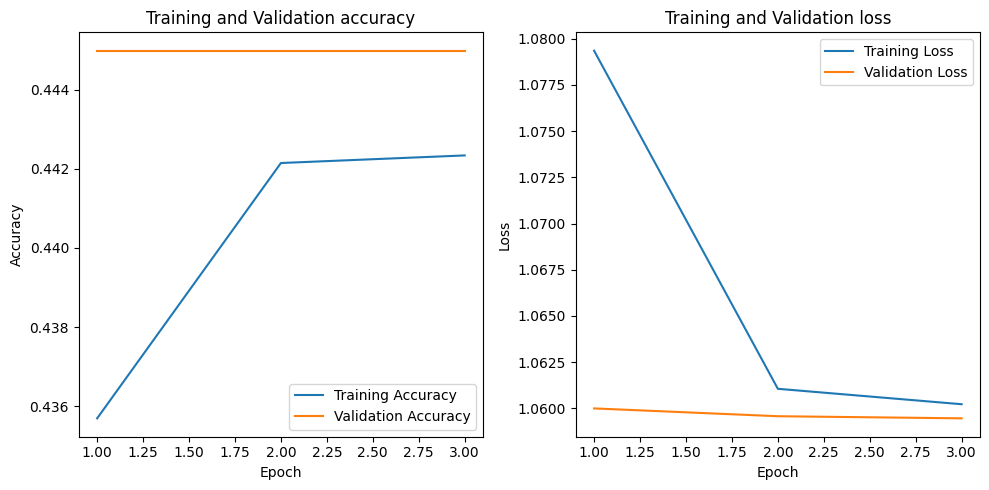

In [59]:
# Plot accuracy and loss
plotLearningCurve(r, n_epochs)

In [60]:
print("Evaluate Model Performance on Test set")
result = model_bert.evaluate(test_dataset.batch(32))
print(dict(zip(model_bert.metrics_names, result)))

Evaluate Model Performance on Test set
1019/1019 [==============================] - 39s 38ms/step - loss: 1.0588 - accuracy: 0.4434
{'loss': 1.0588023662567139, 'accuracy': 0.44342517852783203}


1019/1019 [==============================] - 39s 37ms/step


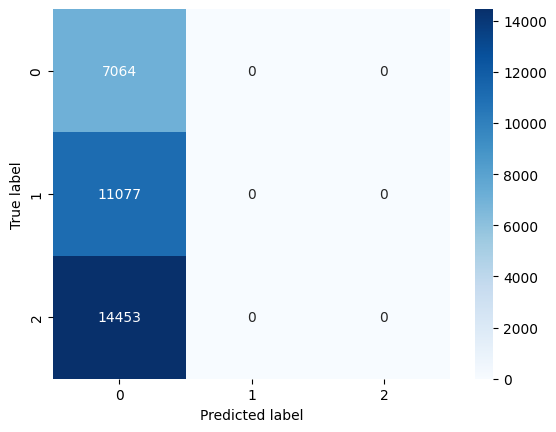

In [61]:
# Generate predictions for the test dataset
ypred = model_bert.predict(test_dataset.batch(32))
ypred = ypred>0.5
# Get the confusion matrix
cf_matrix = confusion_matrix(ytest.values.argmax(axis=1), ypred.argmax(axis=1))
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [62]:
# Save mdel
path_bert = '/content/drive/MyDrive/PU-Y4-S2/Xử lý ngôn ngữ tự nhiên/Midterm/Sentiment_Analysis/Twitter Model/model_bert.h5'
model_bert.save(path_bert)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
